## **MLP Classifier Explained Using Adult Census Dataset**

 An **MLP**, or **Multilayer Perceptron**, is a foundational type of feedforward artificial neural network used for classification tasks. It’s made up of layers of simple units called neurons, where each layer transforms the data a little bit before passing it to the next one. You feed in some numbers, the network mixes and reshapes them through these layers, and out comes a prediction—whether that’s a category, a number, or something else. It’s like stacking many perceptrons so they can solve more complex problems together than a single perceptron ever could.  

 **How it Works**

The process of an MLP classifier involves two main phases:

**Forward Propagation:** Input data flows through the network from the input layer, through the hidden layers, to the output layer. At each neuron, a weighted sum of the inputs is calculated, a bias is added, and the result is passed through a non-linear activation function (e.g., ReLU or tanh). This non-linearity is what allows MLPs to learn complex decision boundaries.

**Backpropagation (Learning):** After a prediction is made, a loss function (e.g., cross-entropy) measures the error between the predicted output and the actual target label. This error is then propagated backward through the network, and an optimization algorithm (like Stochastic Gradient Descent or Adam) uses this information to iteratively adjust the weights and biases to minimize the error. This iterative process is repeated over the entire dataset for a set number of epochs (iterations).



**SETUPS & IMPORTS**

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier

from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, classification_report, confusion_matrix
)

from sklearn.inspection import PartialDependenceDisplay

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

**Load Dataset**

In [3]:
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data"

columns = [
    "age", "workclass", "fnlwgt", "education", "education-num",
    "marital-status", "occupation", "relationship", "race", "sex",
    "capital-gain", "capital-loss", "hours-per-week", "native-country",
    "income"
]

df = pd.read_csv(url, names=columns, na_values=" ?", skipinitialspace=True)

print(df.head(5))

   age         workclass  fnlwgt  education  education-num  \
0   39         State-gov   77516  Bachelors             13   
1   50  Self-emp-not-inc   83311  Bachelors             13   
2   38           Private  215646    HS-grad              9   
3   53           Private  234721       11th              7   
4   28           Private  338409  Bachelors             13   

       marital-status         occupation   relationship   race     sex  \
0       Never-married       Adm-clerical  Not-in-family  White    Male   
1  Married-civ-spouse    Exec-managerial        Husband  White    Male   
2            Divorced  Handlers-cleaners  Not-in-family  White    Male   
3  Married-civ-spouse  Handlers-cleaners        Husband  Black    Male   
4  Married-civ-spouse     Prof-specialty           Wife  Black  Female   

   capital-gain  capital-loss  hours-per-week native-country income  
0          2174             0              40  United-States  <=50K  
1             0             0             

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             32561 non-null  int64 
 1   workclass       32561 non-null  object
 2   fnlwgt          32561 non-null  int64 
 3   education       32561 non-null  object
 4   education-num   32561 non-null  int64 
 5   marital-status  32561 non-null  object
 6   occupation      32561 non-null  object
 7   relationship    32561 non-null  object
 8   race            32561 non-null  object
 9   sex             32561 non-null  object
 10  capital-gain    32561 non-null  int64 
 11  capital-loss    32561 non-null  int64 
 12  hours-per-week  32561 non-null  int64 
 13  native-country  32561 non-null  object
 14  income          32561 non-null  object
dtypes: int64(6), object(9)
memory usage: 3.7+ MB


##  **DATA PREPROCESSING**
All features were encoded into numeric, as well as conducting necessary cleaning and preprocessing for MLP.



In [6]:
categorical_cols = df.select_dtypes(include="object").columns.drop("income")
df[categorical_cols] = df[categorical_cols].fillna("Unknown")

In [7]:
df.shape

(32561, 15)

## **TRAIN-VALIDATION-TEST SPLIT**

In [10]:
X = df.drop("income", axis=1)
y = df["income"].apply(lambda x: 1 if x == ">50K" else 0)

X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, y, test_size=0.15, stratify=y, random_state=RANDOM_STATE
)

X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val,
    test_size=0.176,
    stratify=y_train_val,
    random_state=RANDOM_STATE
)

#**Preprocessing Pipeline**

**Scaling** numerical data and **Encoding** categorical data

In [12]:
numeric_cols = X.select_dtypes(include=["int64", "float64"]).columns
categorical_cols = X.select_dtypes(include=["object"]).columns

preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numeric_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), categorical_cols)
    ]
)

# **BASELINE MODELS (FOR BENCHMARKING)**

Logistic Regression and Decision Tree represent two strong but very different baselines. Logistic Regression helps us see how a simple linear model performs. It’s the benchmark for understanding whether my neural network is actually learning something deeper or just adding complexity. On the other hand, Decision Tree is a nonlinear model that captures feature interactions well. By comparing against both, I can show that my MLP not only handles nonlinear patterns as Decision Tree, but also understands the data instead of just memorizing it.

**LOGISTIC REGRESSION**

In [13]:
log_reg = Pipeline([
    ("prep", preprocessor),
    ("model", LogisticRegression(
        max_iter=500,
        class_weight="balanced"
    ))
])

log_reg.fit(X_train, y_train)

Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  Index(['age', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss',
       'hours-per-week'],
      dtype='object')),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  Index(['workclass', 'education', 'marital-status', 'occupation',
       'relationship', 'race', 'sex', 'native-country'],
      dtype='object'))])),
                ('model',
                 LogisticRegression(class_weight='balanced', max_iter=500))])

**DECISION TREE**

In [14]:
tree = Pipeline([
    ("prep", preprocessor),
    ("model", DecisionTreeClassifier(
        max_depth=8,
        min_samples_leaf=200,
        random_state=RANDOM_STATE
    ))
])

tree.fit(X_train, y_train)

Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  Index(['age', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss',
       'hours-per-week'],
      dtype='object')),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  Index(['workclass', 'education', 'marital-status', 'occupation',
       'relationship', 'race', 'sex', 'native-country'],
      dtype='object'))])),
                ('model',
                 DecisionTreeClassifier(max_depth=8, min_samples_leaf=200,
                                        random_state=42))])

#**TUNING FOR MLP**

As GridSearchCV was slow, I tested a set
of (alpha, learning_rate) combinations on the validation set only.
Besides, I used **Adam** solver for its computational efficiency. **Early Stopping** was used for regularisation, and prevention of overfitting. **ReLU** was used to mitigate vanishing gradient problems.

---



In [15]:
mlp_configs = [
    {"alpha": 1e-4, "lr": 0.001},
    {"alpha": 1e-3, "lr": 0.001},
    {"alpha": 1e-3, "lr": 0.0005}
]

results = []

for cfg in mlp_configs:
    mlp = Pipeline([
        ("prep", preprocessor),
        ("model", MLPClassifier(
            hidden_layer_sizes=(128, 64),
            activation="relu",
            solver="adam",
            alpha=cfg["alpha"],
            learning_rate_init=cfg["lr"],
            batch_size=64,
            max_iter=300,
            early_stopping=True,
            validation_fraction=0.1,
            n_iter_no_change=10,
            random_state=RANDOM_STATE
        ))
    ])

    mlp.fit(X_train, y_train)

    val_probs = mlp.predict_proba(X_val)[:, 1]
    val_f1 = f1_score(y_val, mlp.predict(X_val))
    val_auc = roc_auc_score(y_val, val_probs)

    results.append((cfg, val_f1, val_auc))

**Choosing the Best Configuration for Validation**

In [16]:
results_df = pd.DataFrame(results, columns=["Config", "Val_F1", "Val_ROC_AUC"])
results_df.sort_values(by="Val_F1", ascending=False)

,Config,Val_F1,Val_ROC_AUC
2,"{'alpha': 0.001, 'lr': 0.0005}",0.663487,0.898095
0,"{'alpha': 0.0001, 'lr': 0.001}",0.654214,0.896173
1,"{'alpha': 0.001, 'lr': 0.001}",0.652527,0.897838


In [18]:
best_config = results_df.sort_values("Val_F1", ascending=False).iloc[0]["Config"]
best_config

{'alpha': 0.001, 'lr': 0.0005}

## **THE MLP MODEL**

In [19]:
final_mlp = Pipeline([
    ("prep", preprocessor),
    ("model", MLPClassifier(
        hidden_layer_sizes=(128, 64),
        activation="relu",
        solver="adam",
        alpha=best_config["alpha"],
        learning_rate_init=best_config["lr"],
        batch_size=64,
        max_iter=300,
        early_stopping=True,
        validation_fraction=0.1,
        n_iter_no_change=10,
        random_state=RANDOM_STATE
    ))
])

final_mlp.fit(X_train, y_train)

Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  Index(['age', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss',
       'hours-per-week'],
      dtype='object')),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  Index(['workclass', 'education', 'marital-status', 'occupation',
       'relationship', 'race', 'sex', 'native-country'],
      dtype='object'))])),
                ('model',
                 MLPClassifier(alpha=0.001, batch_size=64, early_stopping=True,
                               hidden_layer_sizes=(128, 64),
                               learning_rate_init=0.0005, max_iter=300,
                               random_state=42))])

## **MODEL EVALUATION**


In [46]:
def evaluate(model, X, y, name):
    preds = model.predict(X)
    probs = model.predict_proba(X)[:, 1]

    print(f"\n{name}")
    print("-" * 40)
    print("Accuracy :", accuracy_score(y, preds))
    print("Precision:", precision_score(y, preds))
    print("Recall   :", recall_score(y, preds))
    print("F1-score :", f1_score(y, preds))
    print("ROC-AUC  :", roc_auc_score(y, probs))

## **MODEL COMPARISON ON VALIDATION SET**

In [48]:
evaluate(log_reg, X_val, y_val, "Logistic Regression (Validation)")
evaluate(tree, X_val, y_val, "Decision Tree (Validation)")
evaluate(final_mlp, X_val, y_val, "Tuned MLP (Validation)")


Logistic Regression (Validation)
----------------------------------------
Accuracy : 0.7979880927940874
Precision: 0.5543415756181713
Recall   : 0.8218243819266837
F1-score : 0.6620879120879121
ROC-AUC  : 0.8949082866386613

Decision Tree (Validation)
----------------------------------------
Accuracy : 0.8353520837610346
Precision: 0.713463751438435
Recall   : 0.5285592497868713
F1-score : 0.6072477962781586
ROC-AUC  : 0.8836325204241644

Tuned MLP (Validation)
----------------------------------------
Accuracy : 0.8406897967563128
Precision: 0.675198587819947
Recall   : 0.6521739130434783
F1-score : 0.6634865568083261
ROC-AUC  : 0.8980951893537531



MLP performs better than its baseline models.

### **PLOT CONFUSION MATRICES**

Both raw and normalised CMs are shown, as normalised CMs allow improved recall for minority class.

In [63]:
from sklearn.metrics import confusion_matrix

def plot_validation_cms_all(models, model_names, X_val, y_val):
    """
    Plots both raw and normalized confusion matrices for multiple models
    in side-by-side subplots (Validation set)
    """
    n_models = len(models)
    fig, axes = plt.subplots(2, n_models, figsize=(5*n_models, 10))

    for i, (model, name) in enumerate(zip(models, model_names)):
        # RAW confusion matrix
        cm_raw = confusion_matrix(y_val, model.predict(X_val))
        sns.heatmap(
            cm_raw,
            annot=True,
            fmt="d",
            cmap="Blues",
            ax=axes[0, i],
            cbar=False
        )
        axes[0, i].set_title(f"{name} - Raw CM")
        axes[0, i].set_xlabel("Predicted")
        axes[0, i].set_ylabel("Actual")

        # NORMALIZED confusion matrix (row-normalized)
        cm_norm = confusion_matrix(y_val, model.predict(X_val), normalize="true")
        sns.heatmap(
            cm_norm,
            annot=True,
            fmt=".2f",
            cmap="Greens",
            ax=axes[1, i],
            cbar=False
        )
        axes[1, i].set_title(f"{name} - Normalized CM")
        axes[1, i].set_xlabel("Predicted")
        axes[1, i].set_ylabel("Actual")

    plt.suptitle("Validation Set Confusion Matrices - Raw & Normalized", fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()


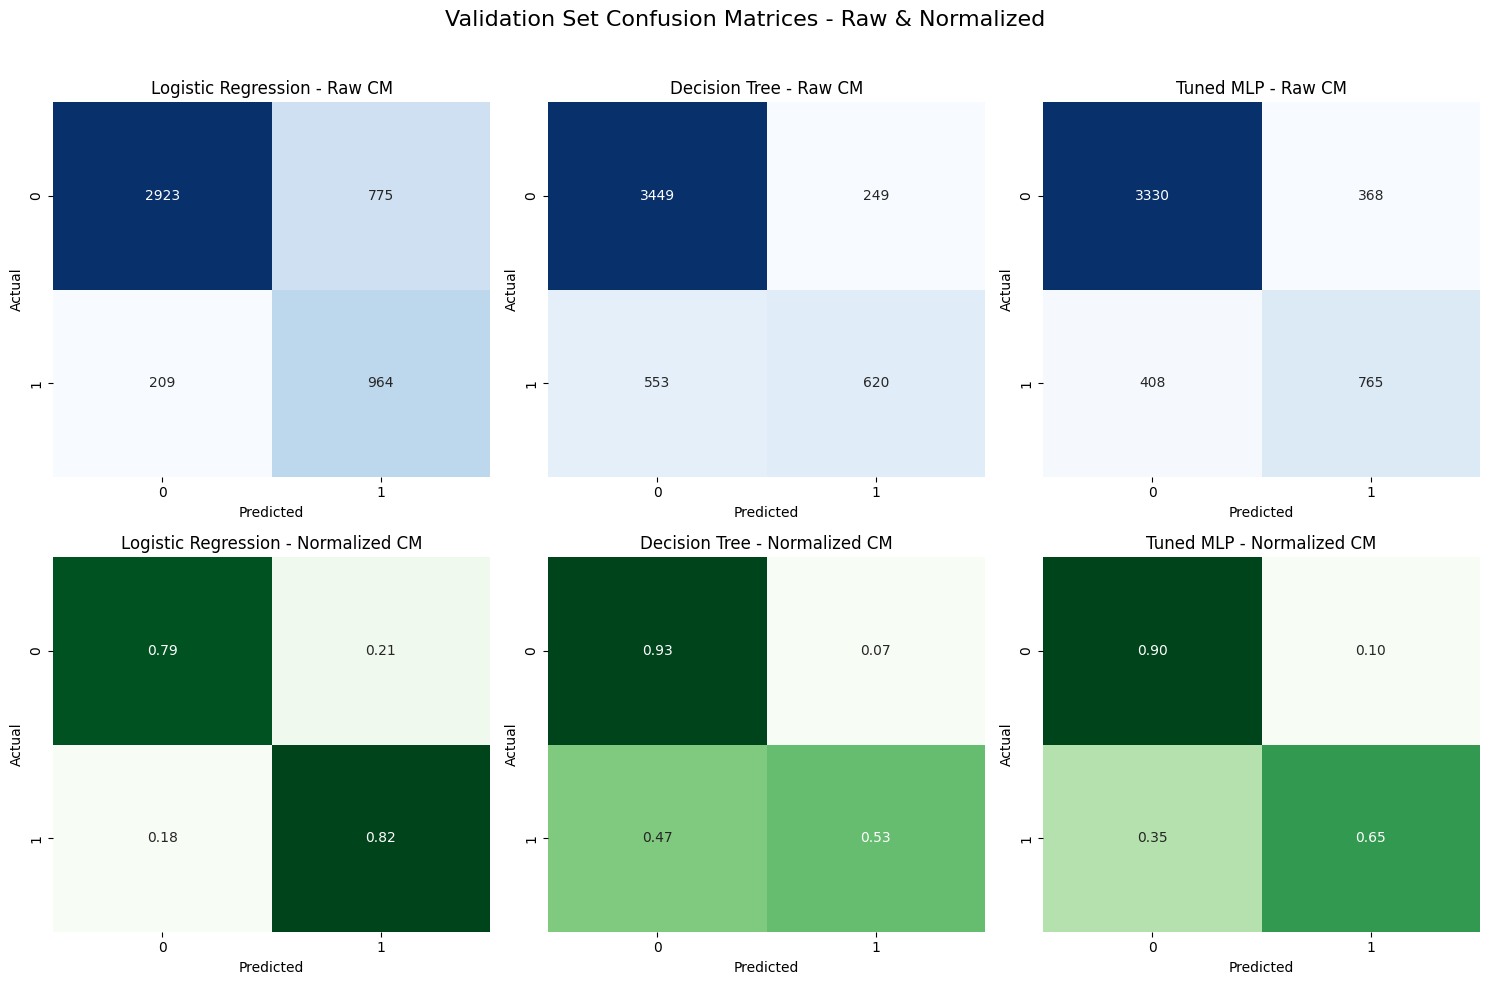

In [64]:
models = [log_reg, tree, final_mlp]
model_names = ["Logistic Regression", "Decision Tree", "Tuned MLP"]

plot_validation_cms_all(models, model_names, X_val, y_val)


**Interpreting the Confusion Matrices**

True Positives: LR>MLP>DT

True Negatives: DT>MLP>LR

False Positives: LR>MLP>DT

False Negatives: DT>MLP>LR

LR exhibits conservative prediction, leading to highest TPs at the cost of highest FPs. DT has highest TNs at the cost of highest FNs.

The MLP achieves the most balanced trade-off across TP, TN, FP, and FN. It avoids extreme bias towards either class.

## **FINAL MLP TEST EVALUATION**

In [49]:
evaluate(final_mlp, X_test, y_test, "Final MLP (Test Set)")
print(classification_report(y_test, final_mlp.predict(X_test)))


Final MLP (Test Set)
----------------------------------------
Accuracy : 0.8560900716479017
Precision: 0.70335339638865
Recall   : 0.6955782312925171
F1-score : 0.6994442069260368
ROC-AUC  : 0.9190411538031227
              precision    recall  f1-score   support

           0       0.90      0.91      0.91      3709
           1       0.70      0.70      0.70      1176

    accuracy                           0.86      4885
   macro avg       0.80      0.80      0.80      4885
weighted avg       0.86      0.86      0.86      4885



## **MODEL INTERPRETATION**

**PARTIAL DEPENDENCE PLOTS**

PDPs help verify whether the model learned economically and socially sensible relationships.


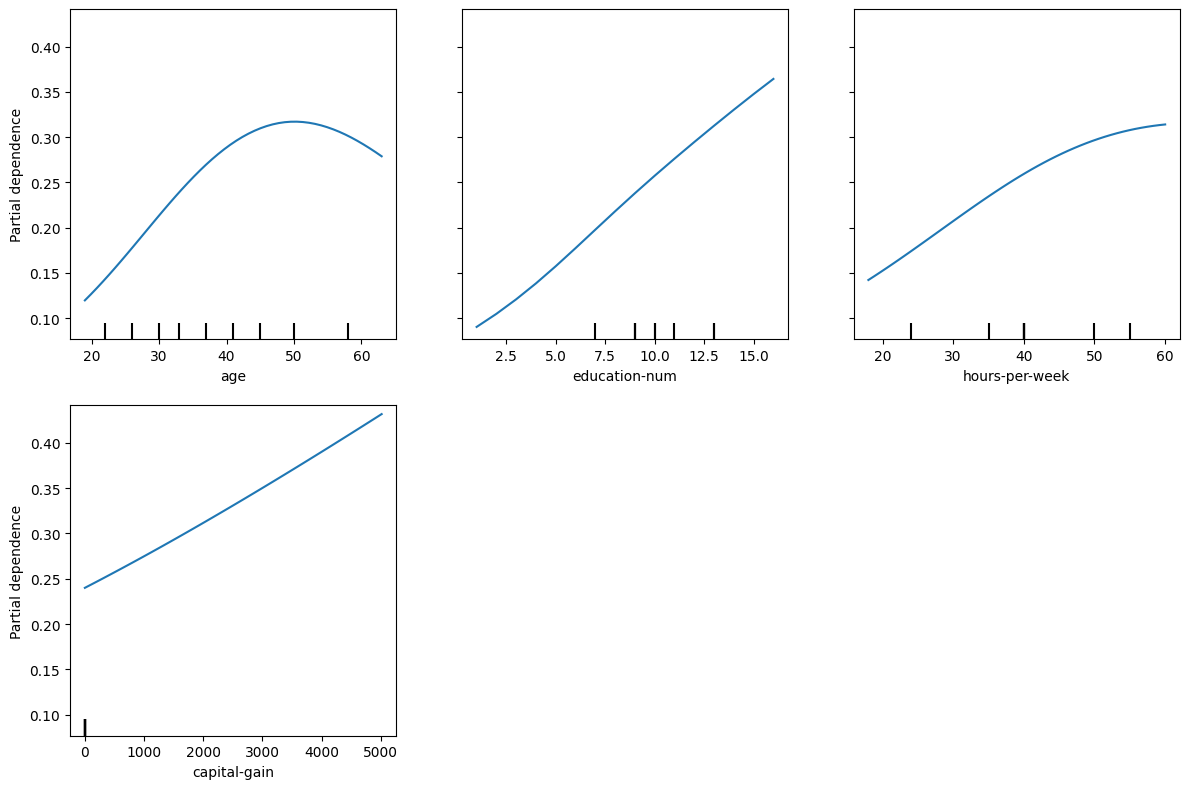

In [38]:
features = ["age", "education-num", "hours-per-week", "capital-gain"]

fig, ax = plt.subplots(figsize=(12, 8))
PartialDependenceDisplay.from_estimator(
    final_mlp,
    X_train,
    features=features,
    grid_resolution=50,
    ax=ax
)
plt.tight_layout()
plt.show()

**Interpretating PDPs**

Income ↑ with education

Income ↑ with hours worked (up to a point, after which number of hours has a diminishing impact on the prediction)

Income ↑ sharply with capital gains

Income ↑ with age until 45-50 years, after which effect starts to slightly decrease.

## **CONFUSION MATRIX - TEST SET**

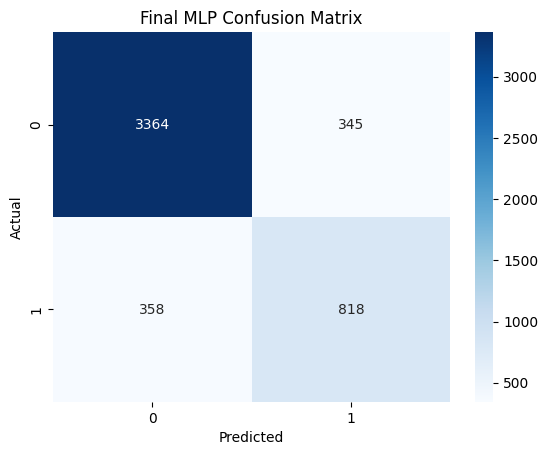

In [65]:
cm = confusion_matrix(y_test, final_mlp.predict(X_test))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Final MLP Confusion Matrix")
plt.show()

The test set confusion matrix confirms that the Multilayer Perceptron generalises well to unseen data. It maintains a balanced trade-off between false positives and false negatives. Unlike Logistic Regression and Decision Trees, which favor precision and recall respectively, the MLP provides stable and robust performance across all error types, making it the most suitable model for income prediction.

#**COMPARISON WITH PROJECT 1 MODEL PERFORMANCE**

For my Project 1, I used MLP Classifier on the same dataset. However, this time, I further tuned it for better performance.

### **Confusion Matrices Comparison**

**Project 1**

TP: 701 ; TN: 3100 ; FP: 299 ; FN: 425

**Project 3**

TP: 765 ; TN: 3330 ; FP: 368 ; FN: 408



This project 3 above, after tuning, shows slightly better performance in terms of correctly predicting both classes -- the number of people whose actual income is above 50k and below 50k.